# Effect of Double Quaity Bonues in Medicare Advantage plans 

## Brief Background

This analysis examines the effect of double quality bonuses in select counties on the benefit offerings in Medicare Advantage plans.

The Medicare Advantage Quality Bonus Program (QBP) took effect in 2012 as part of an effort to improve the quality of Medicare Advantage plans. As part of the Medicare Advantage QBP, health insurance companies offering Medicare Advantage plans are eligible for double quality bonuses in certain counties if the counties meet the following criteria.

- Located in a Metropolitan Statistical Area (MSA) of at least 250,000 people
- Below-average Fee-for-Service (FFS) Medicare spending
- At least 25% of Medicare eligibiles enrolling in Medicare Advantage plans.

One important feature to note is that, in 2015, the Quality Bonus Program underwent major changes such as limiting the payments that firms could receive

While previous literature has not found evidence of double-bonuses improving plan-quality, there is no previous work analyzing the effect of this program on the supplemental benefits offered by Medicare Advantage plans. Previous work, such as Scala (2024), finds that individuals do value the supplemental benefits offered in Medicare Advantage plans

In prior analysis, I used data on Medicare Advantage benchmarks to determine if a county was double-bonus eligible, and calculated the fraction of Medicare Advantage plans offered in each county from 2007-2019 that included supplemental benefits such as dental coverage, eyewear coverage, and hearing aid coverage, as well as the average premiums and specialist copays among other variables in each county-year. I also collected county-year-level characteristics from the 2009-2019 ACS five-year estimates, and the 2007-2008 ACS three-year estimates.

I define county $j$ as being treated at time $t$ if it is double-bonus eligible at time $t$.
## This Analysis


In previous code, I identified every county that was double-bonus eligible (385) using Medicare Advantage ratebook files, and randomly select 400 counties that are not double-bonus eligible. I uploaded data to this repository from these 785 counties from 2007-2019.   

I perform the following analysis:

- Summarize the treatment status of counties from 2012 onward.
- Calculate Difference-in-Differences estimates to examine the effect of treatment on the fraction of plans in counties offering dental coverage, eyewear coverage, and hearing aids coverage.


Difference-in-Difference estimates from this subset of counties show that double-bonus eligibility significantly increases the likelihood plans in eligible counties offer dental coverage, has a marginally significant effect (at the 10% level) on the fraction of plans offering eyewear coverage, and does not have a significant effect on the fraction of plans in a county offering hearing aids coverage. 

### Post-Analysis (outside of this code)

Note, since counties can move in-and-out of treatment, a better estimator, and the one I use in the paper, would be the estimator from De Chaisemartin and D'Haultfoeuille (2019). However, this estimator does not currently have a built-in package in Python as of this writing. Stata code to perform this analysis is available upon request.

In [215]:
import os 
import pandas as pd
import numpy as np
from functools import reduce
import pickle
import statsmodels.api as sm
import matplotlib.pyplot as plt


In [88]:
####actual files redacted due to file size 

aggregated_data = pd.read_csv('data/aggregated_sample_data.csv')

In [89]:
aggregated_data['year'] = aggregated_data['year'].astype(int)

(9297, 23)

## Create a table summarizing the treatment status

In [91]:
### creating a lagged treatment variable

aggregated_data_sorted = aggregated_data.sort_values(['county_encoded','year'])
aggregated_data_sorted['lag_treated'] = aggregated_data_sorted.groupby('county_encoded')['treated'].shift(1)

In [98]:
aggregated_data_sorted[['year', 'lag_treated']].query("year > 2011")

,year,lag_treated
157,2012,0.0
158,2013,0.0
159,2014,1.0
160,2015,1.0
161,2016,1.0
...,...,...
8694,2015,1.0
8695,2016,0.0
8696,2017,0.0
8697,2018,0.0


In [117]:
### creating a variable that describes treatment status 
aggregated_data_sorted['treated_detailed'] = pd.NA

aggregated_data_sorted.loc[(aggregated_data_sorted['treated'] == 0) & (aggregated_data_sorted['lag_treated'] == 0), 'treated_detailed'] = 0 #stays untreated
aggregated_data_sorted.loc[(aggregated_data_sorted['treated'] == 1) & (aggregated_data_sorted['lag_treated'] == 1), 'treated_detailed'] = 1 #stays treated
aggregated_data_sorted.loc[(aggregated_data_sorted['treated'] == 1) & (aggregated_data_sorted['lag_treated'] == 0), 'treated_detailed'] = 2 #becomes treated
aggregated_data_sorted.loc[(aggregated_data_sorted['treated'] == 0) & (aggregated_data_sorted['lag_treated'] == 1), 'treated_detailed'] = 3 #becomes untreated
aggregated_data_sorted.loc[(aggregated_data_sorted['treated'].isna()), 'treat_detailed'] = 97 #missing greatment data
aggregated_data_sorted.loc[aggregated_data_sorted['treated'].notna() & aggregated_data_sorted['lag_treated'].isna(), 'treated_detailed'] = 98  # lag missing
aggregated_data_sorted.loc[aggregated_data_sorted['year'] < 2012, 'treat_detailed'] = 99  # before treatment

In [123]:
##creating treatment labels
treatment_labels = {
    0: "county stays untreated",
    1: "county stays treated",
    2: "county becomes treated",
    3: "county leaves treatment",
    97: "treatment data missing",
    98: "lag treatment data missing",
    99: "before treatment"
}

aggregated_data_sorted['treated_detailed_labeled'] = aggregated_data_sorted['treated_detailed'].map(treatment_labels)

In [124]:
tab_labeled = pd.crosstab(aggregated_data_sorted.loc[aggregated_data_sorted['year'] > 2011, 'treated_detailed_labeled'], 
                          aggregated_data_sorted.loc[aggregated_data_sorted['year'] > 2011, 'year'])

In [126]:
###visualizing the treatment status by county and year

tab_labeled

year,2012,2013,2014,2015,2016,2017,2018,2019
treated_detailed_labeled,,,,,,,,
county becomes treated,224,47,79,14,15,26,12,10
county leaves treatment,0,9,41,209,16,31,35,22
county stays treated,0,215,215,79,77,61,53,43
county stays untreated,553,503,419,437,633,608,625,649


## Difference-in-Difference Estimation

In [128]:
aggregated_data_sorted.columns

Index(['Unnamed: 0', 'county_year', 'eyewear_coverage_indicator',
       'monthlyconsolidatedpremiumi', 'dental_coverage_indicator',
       'hearing_aides_coverage_indicator', 'treated', 'untreated', 'excluded',
       'persistent_treated', 'persistent_excluded', 'year',
       'specialist_min_copay', 'county_encoded', 'Median_Household_Income',
       'Total_Population', 'Percent_Hispanic', 'Percent_NonHispanic_Black',
       'Percent_Unemployed', 'Percent_Female', 'Percent_Below_Poverty',
       'Percent_HS', 'Percent_College', 'lag_treated', 'treat_detailed',
       'treated_detailed', 'treat_detailed_label', 'treated_detailed_labeled'],
      dtype='object')

In [155]:
###keeping data without na values for these variables 

aggregated_data_demo = aggregated_data_sorted[['treated', 'dental_coverage_indicator', 'eyewear_coverage_indicator',
                                           'Median_Household_Income','hearing_aides_coverage_indicator', 'monthlyconsolidatedpremiumi', 'county_encoded',
                                           'Total_Population', 'Percent_Hispanic', 'Percent_NonHispanic_Black','year',
                                           'Percent_Unemployed', 'Percent_Female', 'Percent_Below_Poverty',
                                           'Percent_HS']]

In [168]:
###finding the sum of missing values by columns

missing_data_info = aggregated_data_demo.isna().sum()
missing_data_info_post09 = aggregated_data_demo[aggregated_data_demo['year'] >= 2009].isna().sum()
print(missing_data_info)
print(missing_data_info_post09)

treated                               0
dental_coverage_indicator             1
eyewear_coverage_indicator            1
Median_Household_Income               0
hearing_aides_coverage_indicator      1
monthlyconsolidatedpremiumi           0
county_encoded                        0
Total_Population                      0
Percent_Hispanic                    494
Percent_NonHispanic_Black           494
year                                  0
Percent_Unemployed                   96
Percent_Female                        0
Percent_Below_Poverty                 0
Percent_HS                            1
dtype: int64
treated                             0
dental_coverage_indicator           1
eyewear_coverage_indicator          1
Median_Household_Income             0
hearing_aides_coverage_indicator    1
monthlyconsolidatedpremiumi         0
county_encoded                      0
Total_Population                    0
Percent_Hispanic                    0
Percent_NonHispanic_Black           0
year   

Most of the missing data is from years 2007-2008, where I use ACS 3 year estimates instead of five year estimates. The ACS three-year estimates cover less counties than the five-year estimates. 

In [170]:
##dropping missing data

aggregated_data_demo_nona = aggregated_data_demo.dropna()
print(aggregated_data_demo.shape)
print(aggregated_data_demo_nona.shape)

(9297, 15)
(8800, 15)


In [186]:
y1 = aggregated_data_demo_nona[['dental_coverage_indicator']]
y2 = aggregated_data_demo_nona[['eyewear_coverage_indicator']]
y3 = aggregated_data_demo_nona[['hearing_aides_coverage_indicator']]
# y4 = aggregated_data_demo_nona[['monthlyconsolidatedpremiumi']]

#getting county fixed effects
county_fixed_effects = pd.get_dummies(aggregated_data_demo_nona['county_encoded'], prefix='county', drop_first = True)

#getting year_fixed_effects 
year_fixed_effects = pd.get_dummies(aggregated_data_demo_nona['year'], prefix='year', drop_first = True)



X_nocons = aggregated_data_demo_nona[['treated',
                                   'Median_Household_Income',
                                   'Total_Population', 'Percent_Hispanic', 'Percent_NonHispanic_Black',
                                   'Percent_Unemployed', 'Percent_Female', 'Percent_Below_Poverty',
                                   'Percent_HS']]

##combining the datasets
full_controls_nocons = pd.concat([X_nocons, county_fixed_effects, year_fixed_effects], axis = 1)

##adding constant to x variables
full_controls = sm.add_constant(full_controls_nocons).astype(float)

##cluster standard errors at county level
cluster = aggregated_data_demo_nona['county_encoded']

In [192]:
model_dental = sm.OLS(y1, full_controls).fit(cov_type = 'cluster', cov_kwds={'groups': cluster})
model_eyewear = sm.OLS(y2, full_controls).fit(cov_type = 'cluster', cov_kwds={'groups': cluster})
model_hearing = sm.OLS(y3, full_controls).fit(cov_type = 'cluster', cov_kwds={'groups': cluster})

In [201]:
print(model_dental.params['treated'])
print(model_eyewear.bse['treated'])
print(model_hearing.bse['treated'])

0.026238385165437986
0.006817217838633494
0.00749348676182357


### Creating Coefficient Plots with 95% confidence intervals for Dental, Vision, and Hearing Aids Coverage

In [202]:
### creating function that gives coefficient, and std errors for 95% confidence intervals

def basic_regression_stats(model, variable, percent):
    
    coefficient = model.params[variable]
    se = model.bse[variable]
    conf_int = model.conf_int(alpha=1-percent).loc[variable]
    
    return coefficient, se, conf_int[0], conf_int[1]

In [237]:
dental_stats = basic_regression_stats(model_dental, 'treated', 0.95)
eyewear_stats = basic_regression_stats(model_eyewear, 'treated', 0.95)
hearing_stats = basic_regression_stats(model_hearing, 'treated', 0.95)

In [240]:
##creating a dataframe describing the coefficients, standard errors, and confidence intervals of treatment on different benefits to use for plotting

treated_summary = pd.DataFrame({
    'coefficient': [eyewear_stats[0], hearing_stats[0], dental_stats[0]],
    'std_error': [eyewear_stats[1], hearing_stats[1], dental_stats[1]],
    'lower_bound': [eyewear_stats[2], hearing_stats[2], dental_stats[2]],
    'upper_bound': [eyewear_stats[3], hearing_stats[3], dental_stats[3]]
}, index=['Eyewear', 'Hearing Aids', 'Dental'])

#creating new dataframe to make the plot with
treated_summary_plot = treated_summary.reset_index().rename(columns={'index': 'Benefit'})

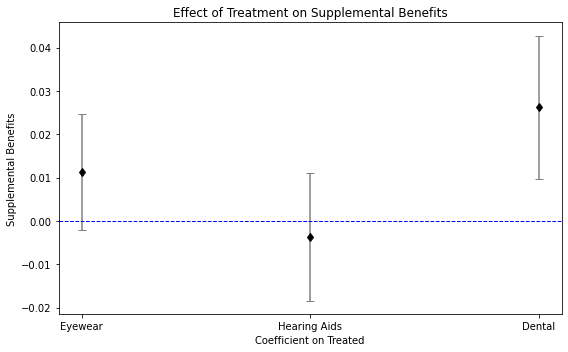

In [239]:
# Plotting Effect of Double Bonuses on Supplemental Benefits in Medicare Advantage plans
plt.figure(figsize=(8, 5))
plt.errorbar(
    y = treated_summary_plot['coefficient'], 
    x= treated_summary_plot['Benefit'], 
    yerr= treated_summary_plot['coefficient'] - treated_summary_plot['lower_bound'], 
    fmt='d', 
    color='black', 
    ecolor='gray', 
    capsize=4
)

plt.axhline(0, color='blue', linestyle='--', linewidth=1)

plt.xlabel('Coefficient on Treated')
plt.ylabel('Supplemental Benefits')
plt.title('Effect of Treatment on Supplemental Benefits')
plt.tight_layout()
plt.show()
